In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import warnings
from tqdm import tqdm_notebook as tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import utils
from constants import DATA_DIR
warnings.filterwarnings('ignore')

In [14]:
df = utils.csv_concatenate(os.path.join(DATA_DIR,'Weighted','base'))

In [15]:
import numpy as np
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
columns = ['G','FG%','FT%','3P','PTS','TRB','AST','STL','TOV']
X = df.loc[:, columns]
y = df['VALUE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=None)
mean_train = np.mean(y_train)
baseline_predictions = np.ones(y_test.shape)*mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
rmse_baseline = math.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline MAE is {:.2f}".format(mae_baseline))
print("Baseline RMSE is {:.2f}".format(rmse_baseline))
#Baseline MAE is 11.3

Baseline MAE is 3.07
Baseline RMSE is 4.00


In [33]:
df = utils.csv_concatenate(os.path.join(DATA_DIR,'Weighted','base'))
columns = ['G','FG%','FT%','3P','PTS','TRB','AST','STL','TOV']
X = df.loc[:, columns]
y = df['VALUE'].values.reshape(-1,1).flatten()
reg = LinearRegression()
errors = utils.cross_val(reg, X, y, n_folds=3, verbose=0)
utils.summarize_errors(errors, verbose=0)


sqrt

   <--- Validation Errors --->
MAE  | Mean: 2.53934, SD: 0.06334
RMSE | Mean: 3.30361, SD: 0.1074



Baseline and weighted data with 9 features: Select best weighting

In [34]:
weights = ['sqrt','linear','quad']

for weight in weights:
    mean = []
    df = utils.csv_concatenate(os.path.join(DATA_DIR,'Weighted',weight))
    df.drop(columns=['PLAYER','TEAM','SEASON'], inplace=True)
    df = pd.get_dummies(df)
    X = df.loc[:, df.columns != 'VALUE']
    y = df['VALUE'].values.reshape(-1,1).flatten()
    reg = LinearRegression()
    print(X.shape)
    errors = utils.cross_val(reg, X, y, n_folds=3, verbose=0)
    print(weight)
    utils.summarize_errors(errors, verbose=0)
    
    #print(sum(mean) / len(mean))
    


(2519, 31)



sqrt

   <--- Validation Errors --->
MAE  | Mean: 2.34072, SD: 0.06421
RMSE | Mean: 3.02609, SD: 0.0951

(2519, 31)



linear

   <--- Validation Errors --->
MAE  | Mean: 2.37155, SD: 0.065
RMSE | Mean: 3.06442, SD: 0.09461

(2519, 31)



quad

   <--- Validation Errors --->
MAE  | Mean: 2.43759, SD: 0.07111
RMSE | Mean: 3.15195, SD: 0.09282



Here's where we add more features and cut them down with feature selection

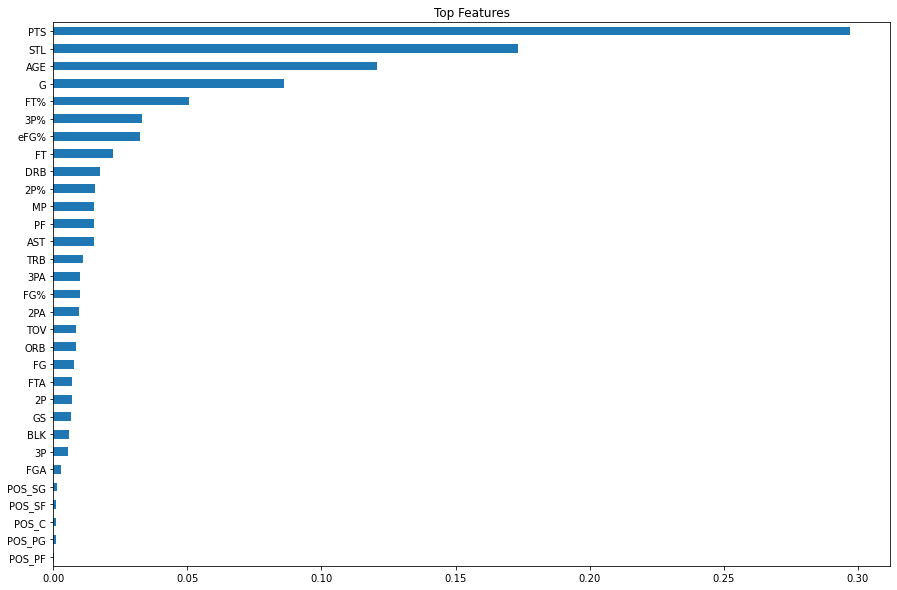

(2519, 32)


In [35]:
#feature selection add more features prior to this?
weight = 'sqrt'
df = utils.csv_concatenate(os.path.join(DATA_DIR,'Weighted',weight))
df.drop(columns=['PLAYER','TEAM','SEASON'], inplace=True)
df = pd.get_dummies(df)
df.fillna(0, inplace=True)
df.to_csv(os.path.join(DATA_DIR,'ABT','abt.csv'), index=False)
X = df.loc[:, df.columns != 'VALUE']
y = df['VALUE']
model = GradientBoostingRegressor()
model.fit(X, y)
column = df.columns.drop(['VALUE'])
top_features = pd.Series(model.feature_importances_, index = column).sort_values()
top_features.plot(kind = "barh", figsize=(15,10) ,title='Top Features')
plt.show()
print(df.shape)

In [36]:
# create ABT
omit_lowest = 5
selected = list(top_features[omit_lowest:].index)
new_abt = df.loc[:,selected]
new_abt['VALUE'] = y
new_abt.to_csv(os.path.join(DATA_DIR,'ABT','data.csv'), index=False)
print(new_abt.shape)

(2519, 27)
